# Grad-CAM for medical applications: How to visualize class activation maps to bring Interpretability to Deep Learning

IMPORTANT: If you are a student from ENSTA, click on "File -> Save a copy in Drive" before using it

In this tutorial, you will learn how to visualize class activation maps using an algorithm called Grad-CAM (original article here: https://arxiv.org/pdf/1611.07450.pdf). It will be implemented using Keras, inspired by the code proposed by Adrian Rosebrock (https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning).

Deep Learning models are considered as “black box” models as we don't know why a certain output is linked to a certain input.

As explained in the original article, "Grad-CAM uses the gradients of any target concept (say logits for “dog” or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." 

Expressed in a simpler way, we can consider that the Grad-CAM method makes it possible to know which part of the image the model looked at to make its decision, or more exactly which part of the image contributed the most to its prediction.

But why would we want to visualize class activation maps in Convolutional Neural Networks? In fact, we want to be sure that the model is taking a decision for the right reason and that is does not contain any inner bias. More concretely and to take a medical example, we want the model to be able to detect an eshophagus because it looks like an eshophagus and not because the context around it makes the network think that this is an eshophagus, as we want to be able to detect an eshophagus in any context. 

The concept is simple and straighforward as we are going to:

1.   find and isolate the final convolutional layer in a pre-trained deep neural network
2.   compute the gradient flowing into that layer and color its value as an heatmap 

We're going to apply this concept to a binary classification task between Eusophagus and Lymphnodes


## Setup

In [ ]:
# Usual Imports for Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Here we are going to use the model VGG16 with pre-trained weights on ImageNet. For the purpose of the fluidity and flow of the tutorial, we don't train the network. Therefore, the classification won't be accurate as it is made on Imagenet weights that do not have Esophagus and Lymphnode classes.

294912/286011 [==============================] - 0s 0us/step


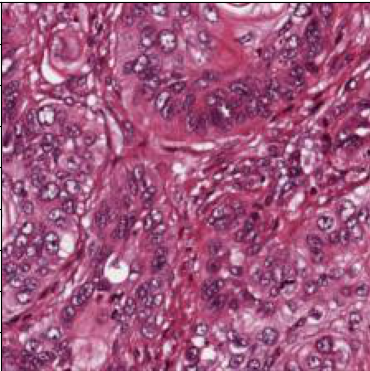

In [ ]:
def eshophagus_lymphnode_classifier():
	inp = keras.layers.Input(shape=(299, 299, 3))
	vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=inp,
									  input_shape=(299, 299, 3))
	vgg.trainable = False

	x = vgg.get_layer('block5_pool').output
	x = tf.keras.layers.GlobalAveragePooling2D()(x)
	x = keras.layers.Dense(64, activation='relu')(x)
	output = keras.layers.Dense(1, activation='sigmoid')(x)

	model = tf.keras.models.Model(inputs=inp, outputs=output)

	return model
# The local path to our target image
img_path = keras.utils.get_file(
    "eshophagus.jpg", "https://i.imgur.com/UjC557V.png"
)


display(Image.open(img_path))



## The Grad-CAM algorithm

In [ ]:
class GradCAM:
    """
    Reference:
        https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
    """

    def __init__(self, model):
        self.model = model
        self.layerName = 'block5_conv3'

        self.gradModel = tf.keras.models.Model(inputs=[self.model.inputs],
                                               outputs=[self.model.get_layer(self.layerName).output, self.model.output])

    def compute_heatmap(self, image, classIdx, eps=1e-8):
        with tf.GradientTape() as tape:
            tape.watch(self.gradModel.get_layer(self.layerName).variables)
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = self.gradModel(inputs)

            if len(predictions) == 1:
                # Binary Classification
                loss = predictions[0]
            else:
                loss = predictions[:, classIdx]

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap


    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)


class GRADCamLogger(tf.keras.callbacks.Callback):
	def __init__(self, validation_data, ):
		super(GRADCamLogger, self).__init__()
		self.validation_data = validation_data
		self.layer_name = layer_name

	def on_epoch_end(self, logs, epoch):
		images = []
		grad_cam = []

		## Initialize GRADCam Class
		cam = GradCAM(model, self.layer_name)

		for image in self.validation_data:
			image = np.expand_dims(image, 0)
			pred = model.predict(image)
			classIDx = np.argmax(pred[0])

			## Compute Heatmap
			heatmap = cam.compute_heatmap(image, classIDx)

			image = image.reshape(image.shape[1:])
			image = image * 255
			image = image.astype(np.uint8)

			## Overlay heatmap on original image
			heatmap = cv2.resize(heatmap, (image.shape[0], image.shape[1]))
			(heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)

			images.append(image)
			grad_cam.append(output)

## Let's use it 

In [ ]:
# Make model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import smart_resize

img_size = (299, 299)

img = cv2.imread(img_path)
img = cv2.resize(img, img_size)
# Prepare image
image = img_to_array(img)



keras.backend.clear_session()
model = eshophagus_lymphnode_classifier()
model.summary()

model.compile('adam', 'binary_crossentropy', ['acc'])

cam = GradCAM(model)
c = 0

image = np.expand_dims(image, 0)
pred = model.predict(image)
classIDx = np.argmax(pred[0])
heatmap = cam.compute_heatmap(image, classIDx)
if pred[0]>0.5:
		label='lymphnode'
else:
		label='esophagus'
print("Predicted:", label)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

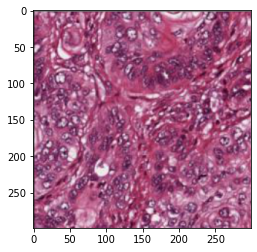

In [ ]:
image = image.reshape(image.shape[1:])
image = np.flip(image, axis=-1) 
image = image.astype(np.uint8)
plt.imshow(image)

## Create a superimposed visualization

Finally, we are going to superimpose this heatmap to the input image in order to easily visualize it. The network focused on the red areas

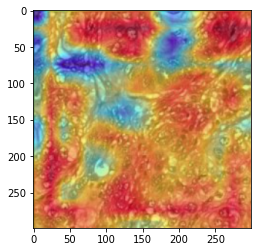

In [ ]:
(heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)

plt.imshow(output)

## Perfect!

Now we know where the model "looked" in order to make its prediction. 

As we're not field expert we don't know if this is right or not but an expert would be able to validate if the network is good or not. 

You can now have fun by testing this method on other images!